In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import cvxpy as cp

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import time

In [2]:
"""
Control problem statement.
"""

N = 4 #number of state variables
M = 2 #number of control variables
T = 20 #Prediction Horizon
DT = 0.2 #discretization step

def get_linear_model(x_bar,u_bar):
    """
    Computes the LTI approximated state space model x' = Ax + Bu + C
    """
    
    L=0.3 #vehicle wheelbase
    
    x = x_bar[0]
    y = x_bar[1]
    v = x_bar[2]
    theta = x_bar[3]
    
    a = u_bar[0]
    delta = u_bar[1]
    
    A = np.zeros((N,N))
    A[0,2]=np.cos(theta)
    A[0,3]=-v*np.sin(theta)
    A[1,2]=np.sin(theta)
    A[1,3]=v*np.cos(theta)
    A[3,2]=v*np.tan(delta)/L
    A_lin=np.eye(N)+DT*A
    
    B = np.zeros((N,M))
    B[2,0]=1
    B[3,1]=v/(L*np.cos(delta)**2)
    B_lin=DT*B
    
    f_xu=np.array([v*np.cos(theta), v*np.sin(theta), a,v*np.tan(delta)/L]).reshape(N,1)
    C_lin = DT*(f_xu - np.dot(A,x_bar.reshape(N,1)) - np.dot(B,u_bar.reshape(M,1)))
    
    return np.round(A_lin,4), np.round(B_lin,4), np.round(C_lin,4)

"""
the ODE is used to update the simulation given the mpc results
I use this insted of using the LTI twice
"""
def kinematics_model(x,t,u):
    """
    Returns the set of ODE of the vehicle model.
    """
    
    L=0.3 #vehicle wheelbase
    dxdt = x[2]*np.cos(x[3])
    dydt = x[2]*np.sin(x[3])
    dvdt = u[0]
    dthetadt = x[2]*np.tan(u[1])/L

    dqdt = [dxdt,
            dydt,
            dvdt,
            dthetadt]

    return dqdt

def predict(x0,u):
    """
    """
    
    x_ = np.zeros((N,T+1))
    
    x_[:,0] = x0
    
    # solve ODE
    for t in range(1,T+1):

        tspan = [0,DT]
        x_next = odeint(kinematics_model,
                         x0,
                         tspan,
                         args=(u[:,t-1],))

        x0 = x_next[1]
        x_[:,t]=x_next[1]
        
    return x_


"""
MODIFIED TO INCLUDE FRAME TRANSFORMATION
"""
def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    """
    Computes a reference path given a set of waypoints
    """
    
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        # watch out to duplicate points!
        final_xp=np.append(final_xp,fx(interp_range)[1:])
        final_yp=np.append(final_yp,fy(interp_range)[1:])
    
    dx = np.append(0, np.diff(final_xp))
    dy = np.append(0, np.diff(final_yp))
    theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp,theta))


def get_nn_idx(state,path):
    """
    Computes the index of the waypoint closest to vehicle
    """

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.hypot(dx,dy)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

    return target_idx

def normalize_angle(angle):
    """
    Normalize an angle to [-pi, pi]
    """
    while angle > np.pi:
        angle -= 2.0 * np.pi

    while angle < -np.pi:
        angle += 2.0 * np.pi

    return angle

def get_ref_trajectory(state, path, target_v):
    """
    modified reference in robot frame
    """
    xref = np.zeros((N, T + 1))
    dref = np.zeros((1, T + 1))
    
    #sp = np.ones((1,T +1))*target_v #speed profile
    
    ncourse = path.shape[1]

    ind = get_nn_idx(state, path)
    dx=path[0,ind] - state[0]
    dy=path[1,ind] - state[1]
    
    xref[0, 0] = dx * np.cos(-state[3]) - dy * np.sin(-state[3]) #X
    xref[1, 0] = dy * np.cos(-state[3]) + dx * np.sin(-state[3]) #Y
    xref[2, 0] = target_v                                        #V
    xref[3, 0] = normalize_angle(path[2,ind]- state[3])          #Theta
    dref[0, 0] = 0.0                                             # steer operational point should be 0
    
    dl = 0.05 # Waypoints spacing [m]
    travel = 0.0
    
    for i in range(T + 1):
        travel += abs(target_v) * DT #current V or target V?
        dind = int(round(travel / dl))
        
        if (ind + dind) < ncourse:
            dx=path[0,ind + dind] - state[0]
            dy=path[1,ind + dind] - state[1]
            
            xref[0, i] = dx * np.cos(-state[3]) - dy * np.sin(-state[3])
            xref[1, i] = dy * np.cos(-state[3]) + dx * np.sin(-state[3])
            xref[2, i] = target_v #sp[ind + dind]
            xref[3, i] = normalize_angle(path[2,ind + dind] - state[3])
            dref[0, i] = 0.0
        else:
            dx=path[0,ncourse - 1] - state[0]
            dy=path[1,ncourse - 1] - state[1]
            
            xref[0, i] = dx * np.cos(-state[3]) - dy * np.sin(-state[3])
            xref[1, i] = dy * np.cos(-state[3]) + dx * np.sin(-state[3])
            xref[2, i] = 0.0 #stop? #sp[ncourse - 1]
            xref[3, i] = normalize_angle(path[2,ncourse - 1] - state[3])
            dref[0, i] = 0.0

    return xref, dref

## SMOOTHEN PATH

I use a corner smoothing tecnique to help the line-finding proplem -> this way the line does not change from 0 to pi/2 instantly

In [3]:
from scipy.signal import savgol_filter
def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    """
    Computes a reference path given a set of waypoints
    """
    
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        # watch out to duplicate points!
        final_xp=np.append(final_xp,fx(interp_range)[1:])
        final_yp=np.append(final_yp,fy(interp_range)[1:])
        
    """this smoothens up corners"""
    window_size = 11 # Smoothening filter window
    final_xp = savgol_filter(final_xp, window_size, 1)
    final_yp = savgol_filter(final_yp, window_size, 1)
    
    dx = np.append(0, np.diff(final_xp))
    dy = np.append(0, np.diff(final_yp))
    theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp,theta))


## V3 Add track constraints
inspried from -> https://arxiv.org/pdf/1711.07300.pdf

explanation here...

benefits:
* add a soft form of obstacle aoidance

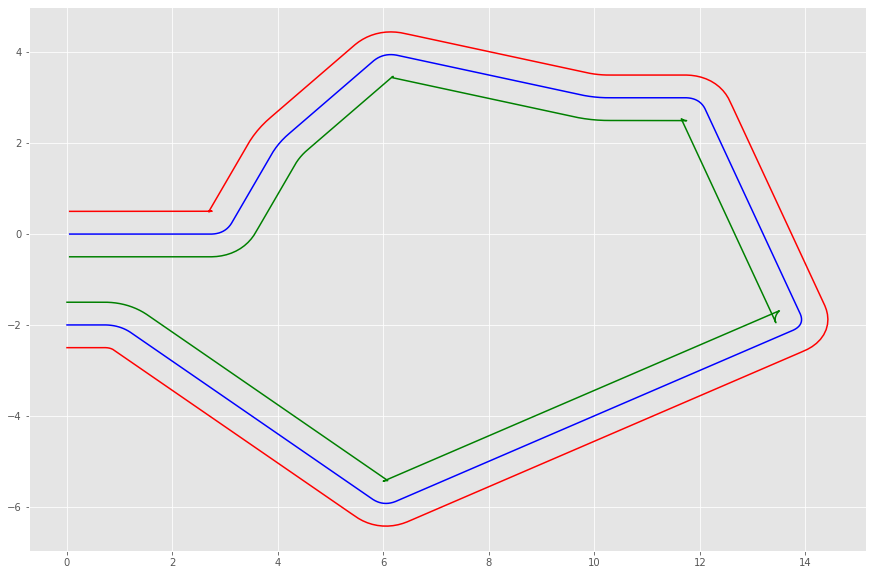

In [4]:
def generate_track_bounds(track,width=0.5):
    """
    in world frame
    """
    bounds_low=np.zeros((2, track.shape[1]))
    bounds_upp=np.zeros((2, track.shape[1]))
    
    for idx in range(track.shape[1]):
        x = track[0,idx]
        y = track [1,idx]
        th = track [2,idx]
        
        """
        trasform the points
        """
        bounds_upp[0, idx] = 0 * np.cos(th) - width * np.sin(th) + x #X
        bounds_upp[1, idx] = 0 * np.sin(th) + width * np.cos(th) + y #Y
        
        bounds_low[0, idx] = 0 * np.cos(th) - (-width) * np.sin(th) + x #X
        bounds_low[1, idx] = 0 * np.sin(th) + (-width) * np.cos(th) + y #Y
        
    return bounds_low, bounds_upp

track = compute_path_from_wp([0,3,4,6,10,12,14,6,1,0],
                             [0,0,2,4,3,3,-2,-6,-2,-2],0.05)

lower, upper = generate_track_bounds(track)

plt.figure(figsize=(15,10))

plt.plot(track[0,:],track[1,:],"b-")
plt.plot(lower[0,:],lower[1,:],"g-")
plt.plot(upper[0,:],upper[1,:],"r-")

the points can be used to generate the **halfplane constrains** for each reference point.
the issues (outliers points) should be gone after we are in vehicle frame...

the halfplane constrains are defined given the line equation:

**lower halfplane**
$$ a1x_1 + b1x_2 = c1 \rightarrow a1x_1 + b1x_2 \leq c1$$

**upper halfplane**
$$ a2x_1 - b2x_2 = c2 \rightarrow a2x_1 + b2x_2 \leq c2$$

we want to combine this in matrix form:

$$
\begin{bmatrix}
x_1 \\
x_2 
\end{bmatrix}
\begin{bmatrix}
a_1 & a_2\\
b_1 & b_2
\end{bmatrix}
\leq
\begin{bmatrix}
c_1 \\
c_2 
\end{bmatrix}
$$

becouse our track points have known heading the coefficients can be computed from:

$$ y - y' = \frac{sin(\theta)}{cos(\theta)}(x - x') $$

we have:

$$
-tan(\theta)x + y =  - tan(\theta)x' + y'
$$
where:
* $ a =  -tan(\theta) $
* $ b = 1 $
* $ c = - tan(\theta)x' + y' $

(-2.0, 2.0)

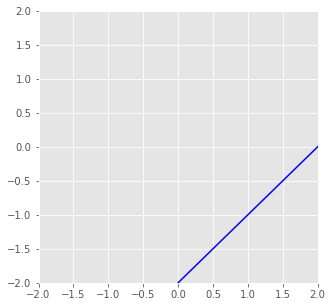

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def get_coeff(x,y,theta):
    m = np.sin(theta)/np.cos(theta)
    return(-m,1,y-m*x)

#test -> assume point 10,1,pi/6
#coeff = get_coeff(1,-1, np.pi/2)
coeff = get_coeff(1,-1, np.pi/4)
y = []
pts = np.linspace(0,20,100)

for x in pts:
    y.append((-coeff[0]*x+coeff[2])/coeff[1])
    
plt.figure(figsize=(5,5))
plt.plot(pts,y,"b-")

plt.xlim((-2, 2))
plt.ylim((-2, 2))

## WARN TANGENT BREAKS AROUND PI/2?
force the equation to x = val

(-2.0, 2.0)

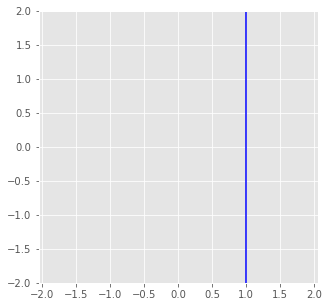

In [6]:
# def get_coeff(x,y,theta):
    
#     if (theta - np.pi/2) < 0.01:
#         #print ("WARN -> theta is 90, tan is: " + str(theta))
#         # eq is x = val
#         m = 0
#         return (1,1e-6,x)
#     else:
#         m = np.sin(theta)/np.cos(theta)
#         return(-m,1,y-m*x)
    
#test -> assume point 10,1,pi/6
coeff = get_coeff(1,-1, np.pi/2)
y = []
pts = np.linspace(0,20,100)

for x in pts:
    y.append((-coeff[0]*x+coeff[2])/coeff[1])
    
plt.figure(figsize=(5,5))

plt.plot(pts,y,"b-")
plt.axis("equal")
plt.xlim((-2, 2))
plt.ylim((-2, 2))

becouse the controller uses vhicle reference frame this rquire adapting -> the semiplane constraints must be gathetered from **x_ref points**

*low and up are w.r.t vehicle y axis*

In [7]:
def get_track_constrains(x_ref, width=0.5):
    """
    x_ref has hape (4,T) -> [x,y,v,theta]_ref 
    """
    
    #1-> get the upper and lower points
    pts_low=np.zeros((3, x_ref.shape[1]))
    pts_upp=np.zeros((3, x_ref.shape[1]))
    
    for idx in range(x_ref.shape[1]):
        x = x_ref [0, idx]
        y = x_ref [1, idx]
        th = x_ref [3, idx]
        
        """
        trasform the points
        """
        pts_upp[0, idx] = 0 * np.cos(th) - width * np.sin(th) + x #X
        pts_upp[1, idx] = 0 * np.sin(th) + width * np.cos(th) + y #Y
        pts_upp[2, idx] = th #heading
        
        pts_low[0, idx] = 0 * np.cos(th) - (-width) * np.sin(th) + x #X
        pts_low[1, idx] = 0 * np.sin(th) + (-width) * np.cos(th) + y #Y
        pts_low[2, idx] = th #heading
    
    #get coefficients ->(a,b,c)
    coeff_low=np.zeros((3, x_ref.shape[1]))
    coeff_upp=np.zeros((3, x_ref.shape[1]))
    
    for idx in range(pts_upp.shape[1]):
        f = get_coeff(pts_low[0,idx],pts_low[1,idx],pts_low[2,idx])
        coeff_low[0,idx]=f[0]
        coeff_low[1,idx]=f[1]
        coeff_low[2,idx]=f[2]
        
        f = get_coeff(pts_upp[0,idx],pts_upp[1,idx],pts_upp[2,idx])
        coeff_upp[0,idx]=f[0]
        coeff_upp[1,idx]=f[1]
        coeff_upp[2,idx]=f[2]
    
    return coeff_low, coeff_upp
    

## MPC INTEGRATION

compare the results with and without

simpe u-turn test

## 1-> NO BOUNDS

In [8]:
track = compute_path_from_wp([0,3,3,0],
                             [0,0,1,1],0.05)

track_lower, track_upper = generate_track_bounds(track,0.12)

sim_duration = 50 #time steps
opt_time=[]

x_sim = np.zeros((N,sim_duration))
u_sim = np.zeros((M,sim_duration-1))

MAX_SPEED = 1.5 #m/s
MAX_ACC = 1.0 #m/ss
MAX_D_ACC = 1.0 #m/sss
MAX_STEER = np.radians(30) #rad
MAX_D_STEER = np.radians(30) #rad/s

REF_VEL = 1.0 #m/s

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0               #x
x0[1] = -0.05           #y
x0[2] = 0.0             #v
x0[3] = np.radians(-0)  #yaw
x_sim[:,0] = x0         #simulation_starting conditions
    
#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:] = MAX_ACC/2 #a
u_bar[1,:] = 0.0      #delta
    
for sim_time in range(sim_duration-1):
    
    iter_start = time.time()
    
    # dynamics starting state w.r.t. robot are always null except vel 
    x_bar = np.zeros((N,T+1))
    x_bar[2,0] = x_sim[2,sim_time]
    
    #prediction for linearization of costrains
    for t in range (1,T+1):
        xt = x_bar[:,t-1].reshape(N,1)
        ut = u_bar[:,t-1].reshape(M,1)
        A,B,C = get_linear_model(xt,ut)
        xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
        x_bar[:,t] = xt_plus_one
    
    #CVXPY Linear MPC problem statement
    x = cp.Variable((N, T+1))
    u = cp.Variable((M, T))
    cost = 0
    constr = []

    # Cost Matrices
    Q = np.diag([20,20,10,20]) #state error cost
    Qf = np.diag([30,30,30,30]) #state final error cost
    R = np.diag([10,10])       #input cost
    R_ = np.diag([10,10])      #input rate of change cost

    #Get Reference_traj
    #dont use x0 in this case
    x_ref, d_ref = get_ref_trajectory(x_sim[:,sim_time] ,track, REF_VEL)
    
    #Prediction Horizon
    for t in range(T):

        # Tracking Error
        cost += cp.quad_form(x[:,t] - x_ref[:,t], Q)

        # Actuation effort
        cost += cp.quad_form(u[:,t], R)

        # Actuation rate of change
        if t < (T - 1):
            cost += cp.quad_form(u[:,t+1] - u[:,t], R_)
            constr+= [cp.abs(u[0, t + 1] - u[0, t])/DT <= MAX_D_ACC]    #max acc rate of change
            constr += [cp.abs(u[1, t + 1] - u[1, t])/DT <= MAX_D_STEER] #max steer rate of change

        # Kinrmatics Constrains (Linearized model)
        A,B,C = get_linear_model(x_bar[:,t], u_bar[:,t])
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t] + C.flatten()]
    
    #Final Point tracking
    cost += cp.quad_form(x[:, T] - x_ref[:, T], Qf)

    # sums problem objectives and concatenates constraints.
    constr += [x[:,0] == x_bar[:,0]]           #starting condition
    constr += [x[2,:] <= MAX_SPEED]           #max speed
    constr += [x[2,:] >= 0.0]                 #min_speed (not really needed)
    constr += [cp.abs(u[0,:]) <= MAX_ACC]     #max acc
    constr += [cp.abs(u[1,:]) <= MAX_STEER]   #max steer
    
    # Solve
    prob = cp.Problem(cp.Minimize(cost), constr)
    solution = prob.solve(solver=cp.OSQP, verbose=False)
    
    #retrieved optimized U and assign to u_bar to linearize in next step
    u_bar = np.vstack((np.array(u.value[0,:]).flatten(),
                    (np.array(u.value[1,:]).flatten())))
    
    u_sim[:,sim_time] = u_bar[:,0]
    
    # Measure elpased time to get results from cvxpy
    opt_time.append(time.time()-iter_start)
    
    # move simulation to t+1
    tspan = [0,DT]
    x_sim[:,sim_time+1] = odeint(kinematics_model,
                                 x_sim[:,sim_time],
                                 tspan,
                                 args=(u_bar[:,0],))[1]
    
print("CVXPY Optimization Time: Avrg: {:.4f}s Max: {:.4f}s Min: {:.4f}s".format(np.mean(opt_time),
                                                                                np.max(opt_time),
                                                                                np.min(opt_time)))   

CVXPY Optimization Time: Avrg: 0.1672s Max: 0.2184s Min: 0.1477s


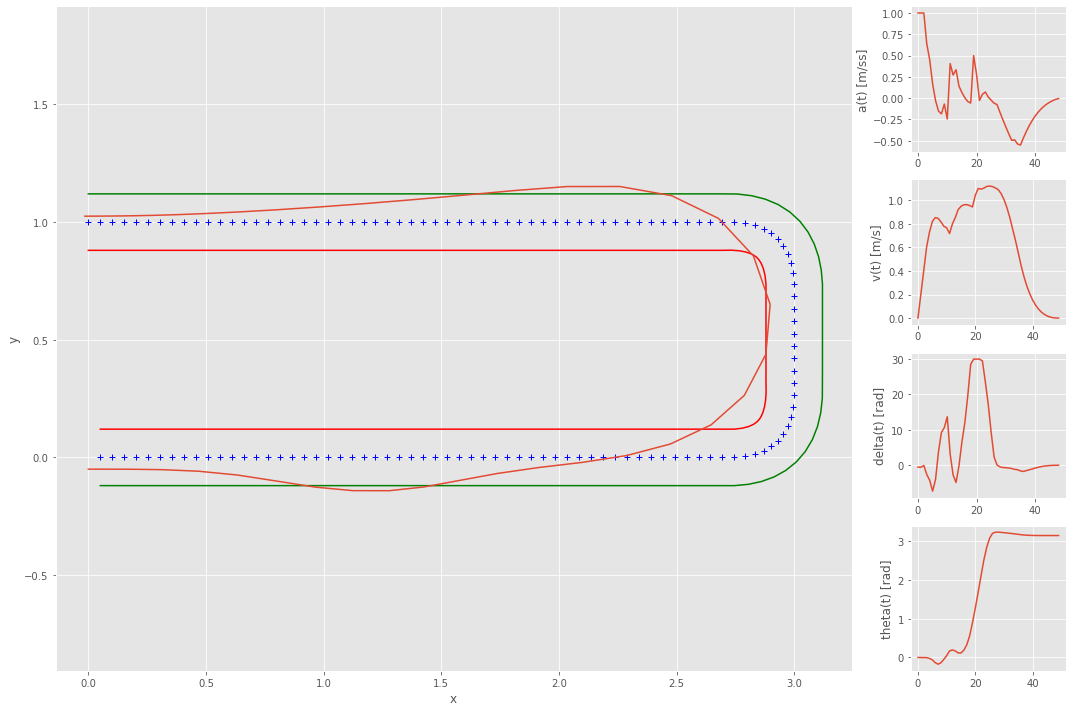

In [9]:
#plot trajectory
grid = plt.GridSpec(4, 5)

plt.figure(figsize=(15,10))

plt.subplot(grid[0:4, 0:4])
plt.plot(track[0,:],track[1,:],"b+")
plt.plot(track_lower[0,:],track_lower[1,:],"g-")
plt.plot(track_upper[0,:],track_upper[1,:],"r-")
plt.plot(x_sim[0,:],x_sim[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(grid[0, 4])
plt.plot(u_sim[0,:])
plt.ylabel('a(t) [m/ss]')

plt.subplot(grid[1, 4])
plt.plot(x_sim[2,:])
plt.ylabel('v(t) [m/s]')

plt.subplot(grid[2, 4])
plt.plot(np.degrees(u_sim[1,:]))
plt.ylabel('delta(t) [rad]')

plt.subplot(grid[3, 4])
plt.plot(x_sim[3,:])
plt.ylabel('theta(t) [rad]')

plt.tight_layout()
plt.show()

## 2-> WITH BOUNDS
if there is 90 deg turn the optimization fails!
if speed is too high it also fails ...

In [13]:
WIDTH=0.25
REF_VEL = 0.2 #m/s

computed_coeff = []

track = compute_path_from_wp([0,3,3,0],
                             [0,0,1,1],0.05)

track_lower, track_upper = generate_track_bounds(track,WIDTH)

sim_duration = 200 #time steps
opt_time=[]

x_sim = np.zeros((N,sim_duration))
u_sim = np.zeros((M,sim_duration-1))

MAX_SPEED = 1.5 #m/s
MAX_ACC = 1.0 #m/ss
MAX_D_ACC = 1.0 #m/sss
MAX_STEER = np.radians(30) #rad
MAX_D_STEER = np.radians(30) #rad/s


# Starting Condition
x0 = np.zeros(N)
x0[0] = 0               #x
x0[1] = -WIDTH/2           #y
x0[2] = 0.0             #v
x0[3] = np.radians(-0)  #yaw
x_sim[:,0] = x0         #simulation_starting conditions
                 
#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:] = MAX_ACC/2 #a
u_bar[1,:] = 0.0      #delta
    
for sim_time in range(sim_duration-1):
    
    iter_start = time.time()
    
    # dynamics starting state w.r.t. robot are always null except vel 
    x_bar = np.zeros((N,T+1))
    x_bar[2,0] = x_sim[2,sim_time]
    
    #prediction for linearization of costrains
    for t in range (1,T+1):
        xt = x_bar[:,t-1].reshape(N,1)
        ut = u_bar[:,t-1].reshape(M,1)
        A,B,C = get_linear_model(xt,ut)
        xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
        x_bar[:,t] = xt_plus_one
    
    #CVXPY Linear MPC problem statement
    x = cp.Variable((N, T+1))
    u = cp.Variable((M, T))
    cost = 0
    constr = []

    # Cost Matrices
    Q = np.diag([20,20,10,20]) #state error cost
    Qf = np.diag([30,30,30,30]) #state final error cost
    R = np.diag([10,10])       #input cost
    R_ = np.diag([10,10])      #input rate of change cost

    #Get Reference_traj
    #dont use x0 in this case
    x_ref, d_ref = get_ref_trajectory(x_sim[:,sim_time] ,track, REF_VEL)
    
    #Prediction Horizon
    for t in range(T):

        # Tracking Error
        cost += cp.quad_form(x[:,t] - x_ref[:,t], Q)

        # Actuation effort
        cost += cp.quad_form(u[:,t], R)

        # Actuation rate of change
        if t < (T - 1):
            cost += cp.quad_form(u[:,t+1] - u[:,t], R_)
            constr+= [cp.abs(u[0, t + 1] - u[0, t])/DT <= MAX_D_ACC]    #max acc rate of change
            constr += [cp.abs(u[1, t + 1] - u[1, t])/DT <= MAX_D_STEER] #max steer rate of change

        # Kinrmatics Constrains (Linearized model)
        A,B,C = get_linear_model(x_bar[:,t], u_bar[:,t])
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t] + C.flatten()]
    
    #Final Point tracking
    cost += cp.quad_form(x[:, T] - x_ref[:, T], Qf)

    # sums problem objectives and concatenates constraints.
    constr += [x[:,0] == x_bar[:,0]]           #starting condition
    constr += [x[2,:] <= MAX_SPEED]           #max speed
    constr += [x[2,:] >= 0.0]                 #min_speed (not really needed)
    constr += [cp.abs(u[0,:]) <= MAX_ACC]     #max acc
    constr += [cp.abs(u[1,:]) <= MAX_STEER]   #max steer
    
    #Track constrains
    low,upp = get_track_constrains(x_ref,WIDTH)
    computed_coeff.append((low,upp))
    for ii in range(low.shape[1]):
        constr += [low[0,ii]*x[0,ii] + x[1,ii] >= low[2,ii]]
        #constr += [upp[0,ii]*x[0,ii] + x[1,ii] <= upp[2,ii]]
    
    # Solve
    prob = cp.Problem(cp.Minimize(cost), constr)
    solution = prob.solve(solver=cp.OSQP, verbose=False)
    
    #retrieved optimized U and assign to u_bar to linearize in next step
    u_bar = np.vstack((np.array(u.value[0,:]).flatten(),
                    (np.array(u.value[1,:]).flatten())))
    
    u_sim[:,sim_time] = u_bar[:,0]
    
    # Measure elpased time to get results from cvxpy
    opt_time.append(time.time()-iter_start)
    
    # move simulation to t+1
    tspan = [0,DT]
    x_sim[:,sim_time+1] = odeint(kinematics_model,
                                 x_sim[:,sim_time],
                                 tspan,
                                 args=(u_bar[:,0],))[1]
    
print("CVXPY Optimization Time: Avrg: {:.4f}s Max: {:.4f}s Min: {:.4f}s".format(np.mean(opt_time),
                                                                                np.max(opt_time),
                                                                                np.min(opt_time))) 

CVXPY Optimization Time: Avrg: 0.1760s Max: 0.2117s Min: 0.1617s


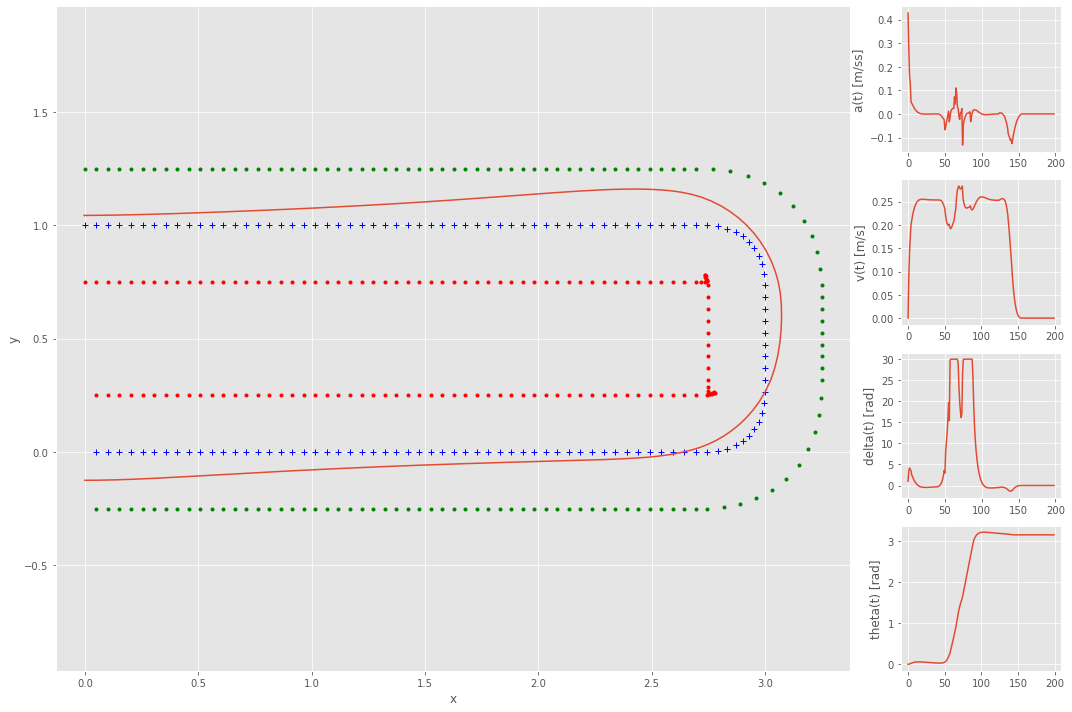

In [14]:
#plot trajectory
grid = plt.GridSpec(4, 5)

plt.figure(figsize=(15,10))

plt.subplot(grid[0:4, 0:4])
plt.plot(track[0,:],track[1,:],"b+")
plt.plot(track_lower[0,:],track_lower[1,:],"g.")
plt.plot(track_upper[0,:],track_upper[1,:],"r.")
plt.plot(x_sim[0,:],x_sim[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(grid[0, 4])
plt.plot(u_sim[0,:])
plt.ylabel('a(t) [m/ss]')

plt.subplot(grid[1, 4])
plt.plot(x_sim[2,:])
plt.ylabel('v(t) [m/s]')


plt.subplot(grid[2, 4])
plt.plot(np.degrees(u_sim[1,:]))
plt.ylabel('delta(t) [rad]')

plt.subplot(grid[3, 4])
plt.plot(x_sim[3,:])
plt.ylabel('theta(t) [rad]')

plt.tight_layout()
plt.show()

## VISUALIZE THE COMPUTED HALF-PLANES

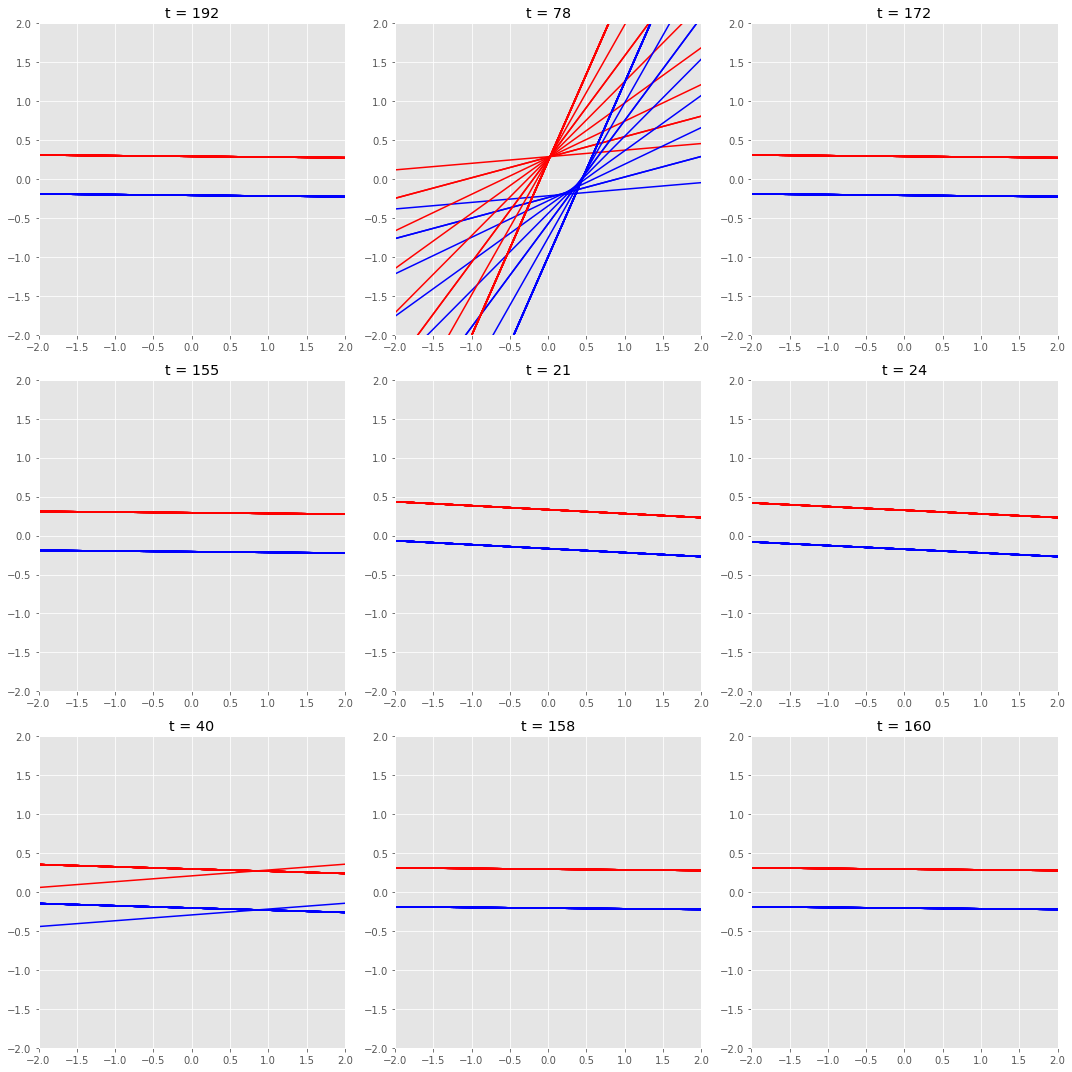

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


def plot_low_upp(low, up):
    """
    low and upp arre arrays of shape (3,N)
    each column represent the couefficient at each
    step of the optimization
    """
    
    #for low,up in zip(low, up):
    for idx in range(low.shape[1]):
        
        ll = low[:,idx]
        uu = up[:,idx]
        
        x = np.linspace(-2,2,100)

        #low
        y = []
        for xx in x:
            y.append((-ll[0]*xx+ll[2])/ll[1])

        plt.plot(x,y,"b-")

        #high
        y = []
        for xx in x:
            y.append((-uu[0]*xx+uu[2])/uu[1])

        plt.plot(x,y,"r-")

        plt.xlim((-2, 2))
        plt.ylim((-2, 2))

def plot_lines():
    """
    sample randomly from computed coeff
    and plot grid
    """
    
    plt.figure(figsize=(15,15))
    indices = np.random.choice(len(computed_coeff), 9)

    for i in range(len(indices)):
        plt.subplot(3,3,i+1)
        plt.title("t = "+str(indices[i]))
        plot_low_upp(computed_coeff[indices[i]][0]
                     ,computed_coeff[indices[i]][1])
    
    plt.tight_layout()
    plt.show()

plot_lines()